# Dao, Project 1: Gradient-based Algorithms and Differentiable Programming


## Problem Formulation.
In this project, we consider the 2D-task of landing a rocket, whose state $x(t)$ is defined as $$x(t) = [x_1(t), x_2(t), \dot{x_1}(t), \dot{x_2}(t)]^T,$$ where $x_1(t)$ and $x_2(t)$ are the rocket's horizontal and vertical locations, respectively, with the center of the landing pad as the origin. Positive vertical velocity is upward, and positive horizontal velocity is rightward. The rocket is controlled by the input $a(t)=[a_1(t), a_2(t)]$ such that its dynamics follow 

$$
\begin{aligned}
x_1(t+1) = x_1(t) + \dot{x_1}(t)\Delta t, \\
x_2(t+1) = x_2(t) + \dot{x_2}(t)\Delta t, \\
\dot{x_1}(t+1) = \dot{x_1}(t) + a_1(t) \Delta t, \\
\dot{x_2}(t+1) = \dot{x_2}(t) + a_2(t) \Delta t,
\end{aligned}
$$

with $\Delta t$ being the discrete time interval. The controller input $a(t)$ is given as 
$$ a(t) = f_{\theta}(x(t)) + D(t) + G. $$ 
In this problem formulation, $f_{\theta}(\cdot)$ is a neural network with optimized parameters $\theta$, $D$ is a drag component defined as $D(t) = [-d\dot{x_1}^2(t), -d\dot{x_2}^2(t)]^T$ where $d$ is a drag constant, and $G$ is a vector defined as  $G = [0, -g]^T,$ where $g$ is the gravitational constant. Hence this simulation takes the assumption that the rocket is not only being acted upon by its own thrust, but also by drag and gravitational forces. 

*From the provided problem statement:*<br>
For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $$l(x(T),a(T)) = ||x(T)||^2.$$ This loss encourages the rocket to reach $x_1, x_2(T)=0$ and $\dot{x_1},\dot{x_2}(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & x_1(t+1) = x_1(t) + \dot{x_1}(t)\Delta t, \\
\quad &x_2(t+1) = x_2(t) + \dot{x_2}(t)\Delta t, \\
\quad & \dot{x_1}(t+1) = \dot{x_1}(t) + a_1(t) \Delta t, \\
\quad & \dot{x_2}(t+1) = \dot{x_2}(t) + a_2(t) \Delta t, \\
\quad & a(t) =  f_{\theta}(x(t)) + Dv(t)^2 + g, ~\forall t=1,...,T-1
\end{aligned}
$$

---
## Programming the Simulation.

In [2]:
# HOUSEKEEPIN' 

import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import random as r

logger = logging.getLogger(__name__)

# ENVIRONMENT PARAMETERS.

FRAME_TIME = 0.1  # time interval (s)
GRAVITY_ACCEL = 0.01  # gravity constant (km/s^2)
BOOST_ACCEL = 0.04  # thrust constant (km/s^2) -- so we can accelerate in one direction MAX at 4 gs
DRAG_CONST = 0.002 # All Cv, rho, area, and 0.5 multiplied together, divided by mass.


In [7]:
# SYSTEM DYNAMICS.

class Dynamics(nn.Module):  # An object to keep all system dynamics.

    def __init__(self):
        super(Dynamics, self).__init__()  # this SUPER allows you to pull other classes. 

    @staticmethod
    def forward(state, action):

        delta_state_matrix=[] # initialize our velocity change matrix.
        for i in range(len(state)):
            # Apply gravity
            delta_state_gravity = t.tensor([0., 0., 0., -GRAVITY_ACCEL * FRAME_TIME])  # GRAVITY ACTS DOWN!
            
            # We gotta add DRAG HERE TOO!!!!
            delta_state_DRAG = t.tensor([0., 0., -DRAG_CONST * state[i,2]**2 * FRAME_TIME,  -DRAG_CONST * state[i,3]**2 * FRAME_TIME])  # Drag is a function of y_dot^2. RESISTS velocity. 
    
            # Thrust
            delta_state_thrust = BOOST_ACCEL * FRAME_TIME * t.tensor([0.,0., 1, 1.]) * t.cat((t.zeros(2),action[i])) 
            # Need to output a 4x1. But 'action' is a 2x1. So let's use TORCH CONCAT to make it a 4x1 with zeros. ALSO, action can be [-1, 1]
            
            delta_state=delta_state_thrust + delta_state_gravity + delta_state_DRAG # All of 'em combined.
            
            delta_state_matrix.append(delta_state) # So we should get N rows.
        
        delt_state_mat_t=t.stack(delta_state_matrix)  # STACK. What a powerful function.
               
       
        # Update VELOCITY. ( Not position. )
        state = state + delt_state_mat_t # need to add two tensors.
       
        
        # Update POSITION.
        step_mat = t.tensor([[1., 0., 0., 0.],
                            [0., 1., 0., 0.],
                            [FRAME_TIME, 0., 1., 0.],
                            [0., FRAME_TIME, 0., 1]])
        state = t.matmul(state,step_mat)
        #print(state)

        return state

#%% a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            # You can add more layers here. DO IT
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # yeah we added another.
            nn.Tanh() # hehehe trying pos or neg
            #nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        #print(action)
        return action

# the SIMULATOR! that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        N=4 # how many do we want to optimize for?
        start_location_lim=.1 # how off-axis side-to-side or up-and-down can it start?
        stdev=start_location_lim/3 # Because 99%+ of the random things should be within this limit.
        state=[[r.gauss(0,stdev), 1-r.gauss(0,stdev),0., 0.]]  # INITIALIZE in km. SO the orignal (x,y) starting point is (0,1) and we're adding some noise to this initial state.
        for i in range(N-1):
            state.append([r.gauss(0,stdev), 1-r.gauss(0,stdev),0., 0.]) # Up until the limit of N.
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        sum_err=0 # initialize
        for i in range (len(state)):
            sum_err+=state[i,0]**2 + state[i,1]**2 + state[i,2]**2 + state[i,3]**2
        return sum_err/len(state)  # AVG ERROR. You want everything to be zero. 

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.1) #0.01

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            self.loss=loss
            #print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize(epoch+1)

    def visualize(self, ep):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)]) # data(a,b,c) where a is the timestep, b is the trajectory (from 0 to N), and c is the state element (x,y,xdot, ydot)
        fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(9,5))
        for i in range(len(data[1,:,1])): # Over the number of trajectories.
            x = data[:,i,:][:,0] # The x position of the i trajectory.
            y = data[:,i,:][:,1] # y position of i trajectory
            dxdt=data[:,i,:][:,2] # x velocity
            dydt=data[:,i,:][:,3] # y velocity 
            ax1.plot(x,y)
            ax2.plot(dxdt)
            ax2.plot(dydt)
            ax1.set_title('[%d] Trajectory (km). Loss = [%.4g]' % (ep,self.loss))
            ax2.set_title('Velocity (km/s) over time')
        plt.show()

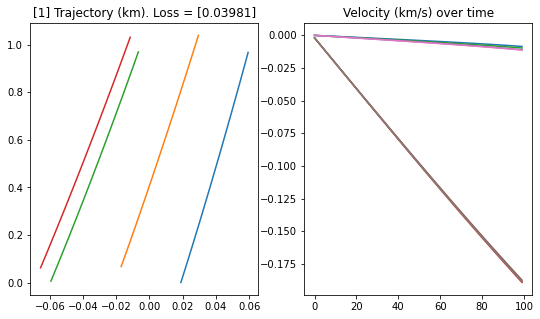

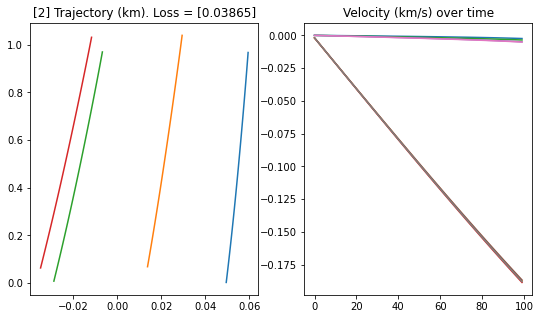

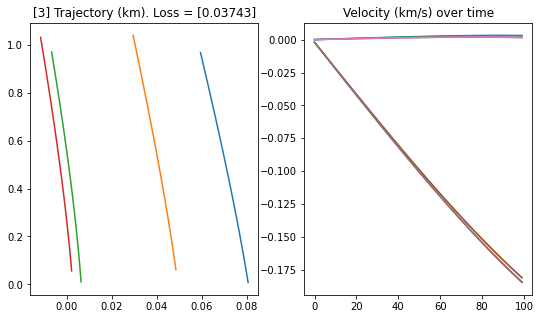

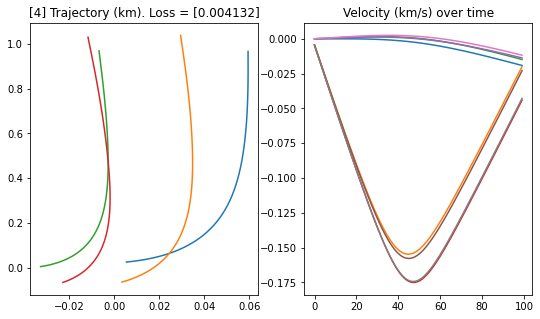

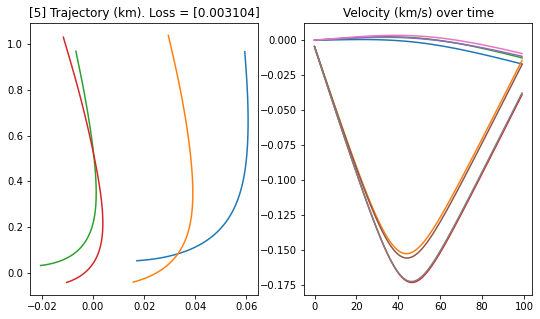

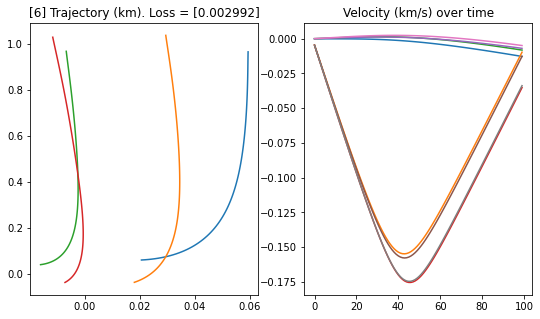

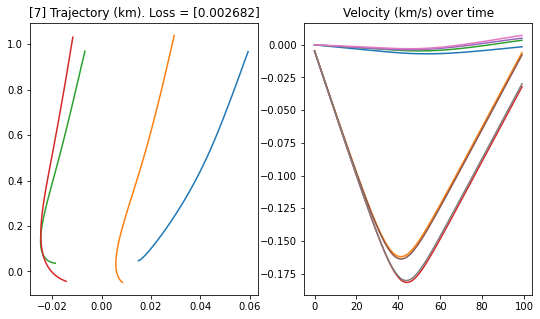

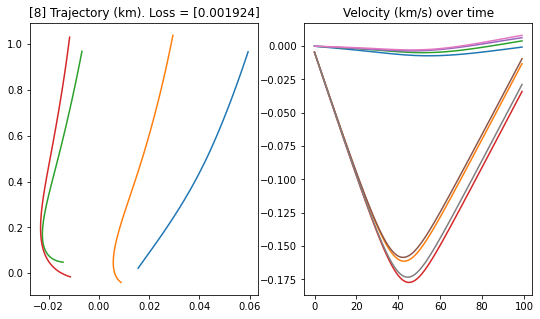

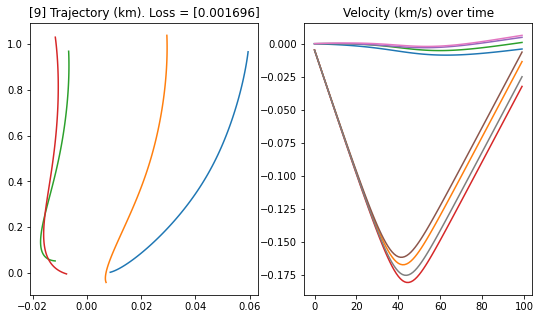

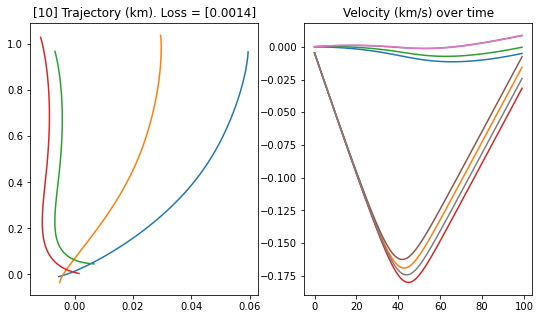

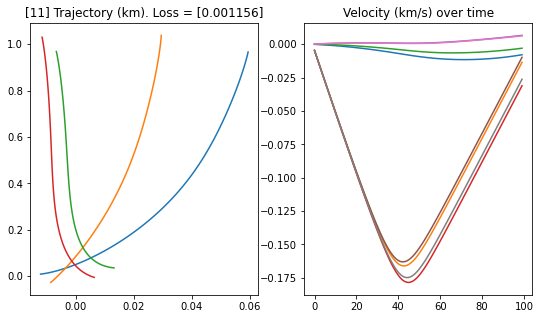

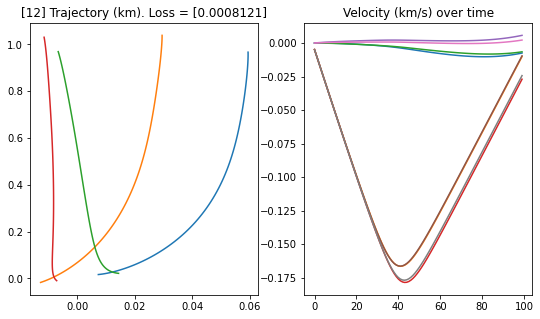

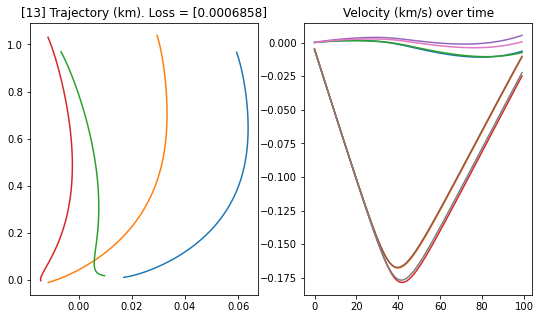

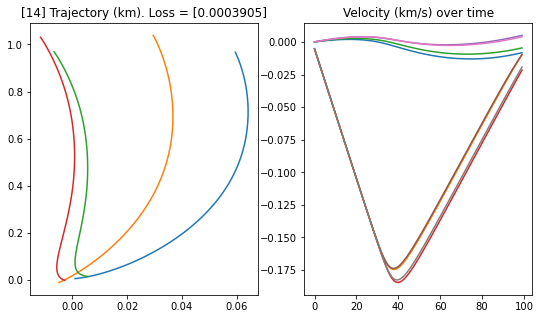

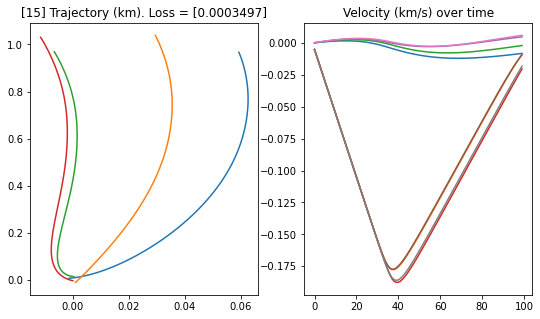

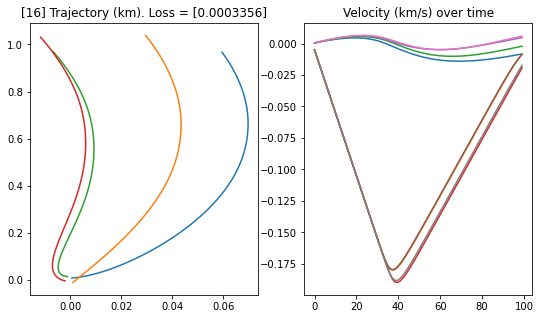

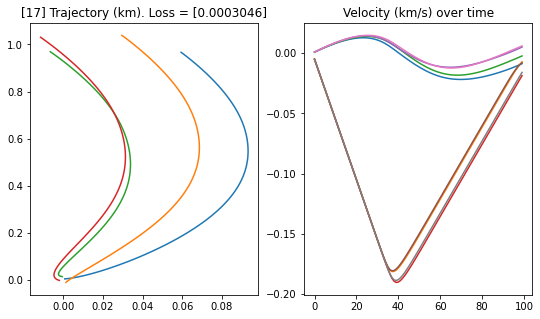

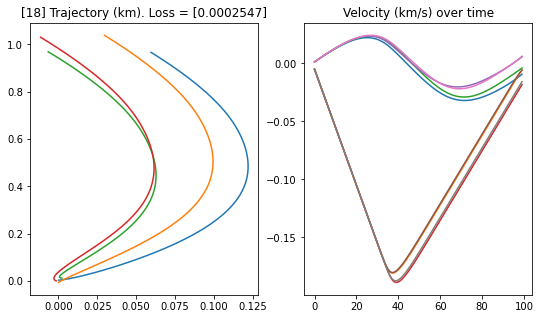

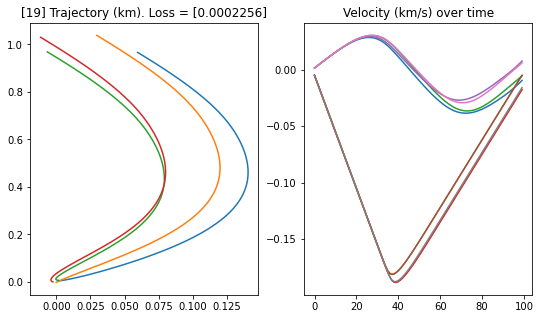

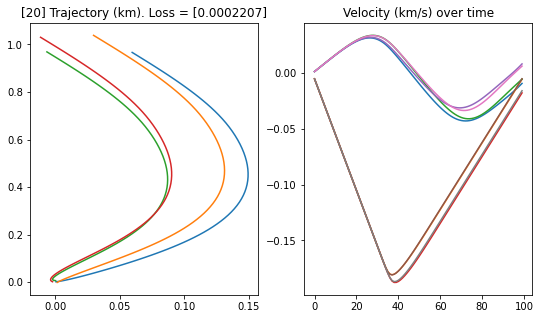

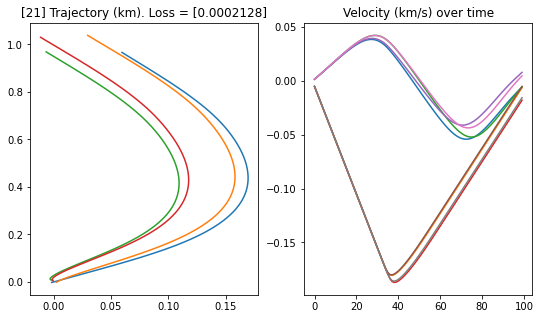

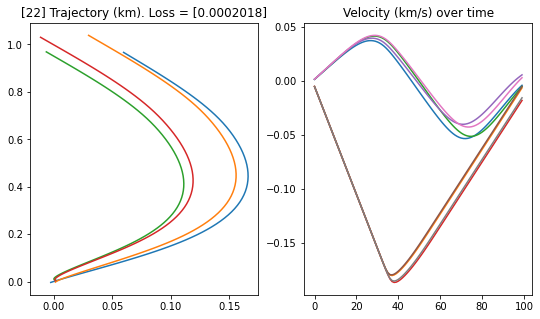

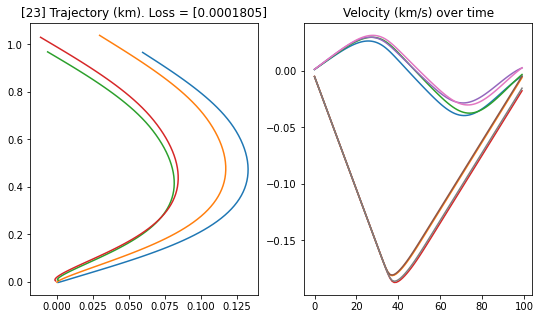

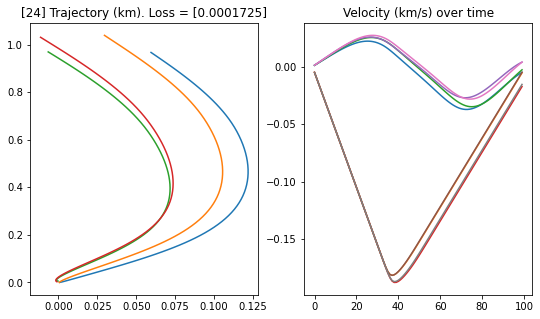

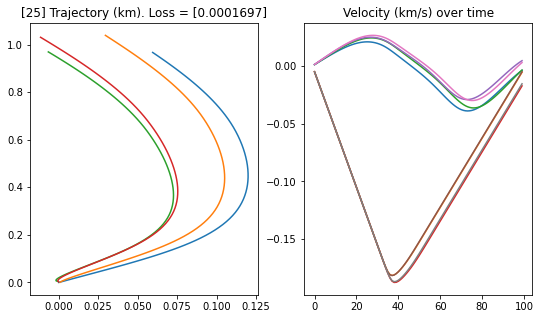

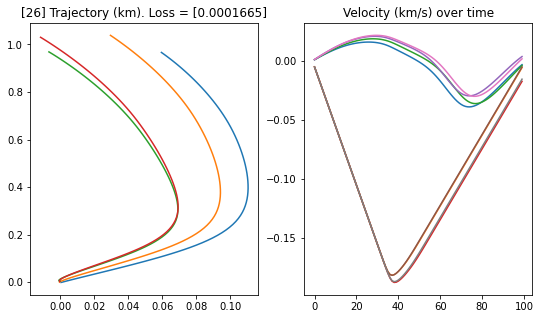

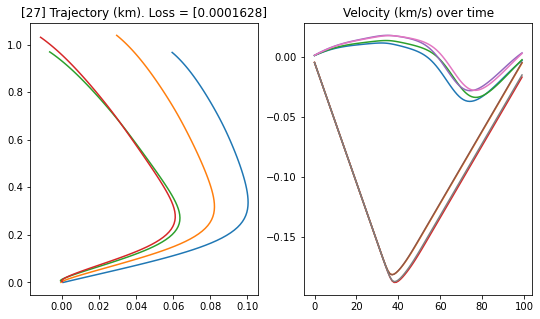

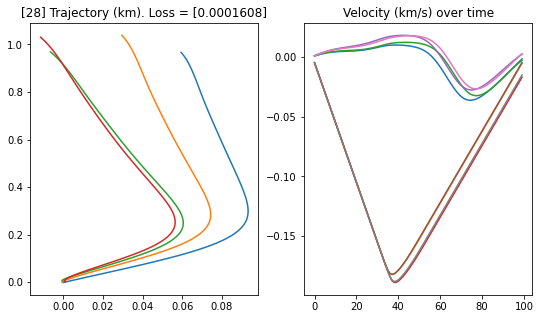

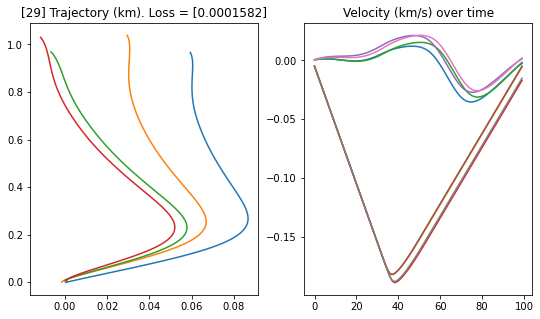

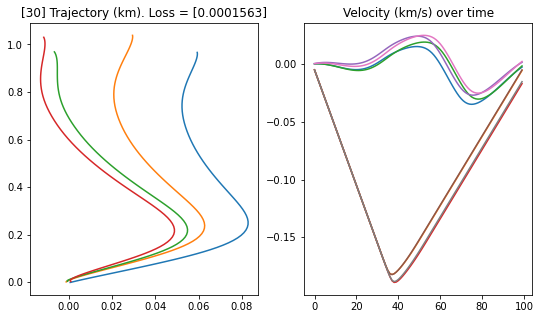

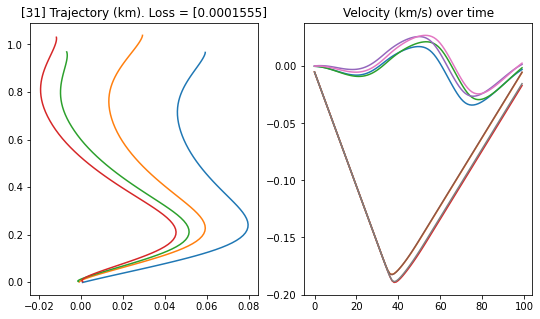

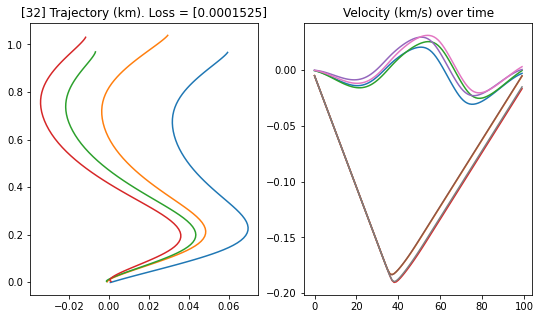

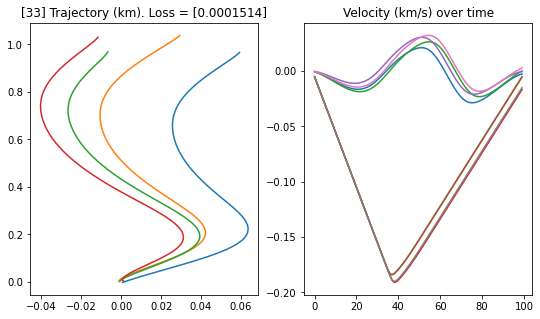

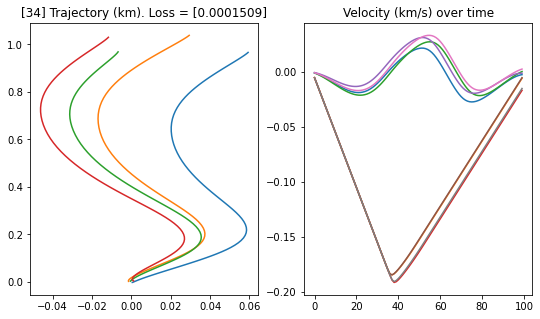

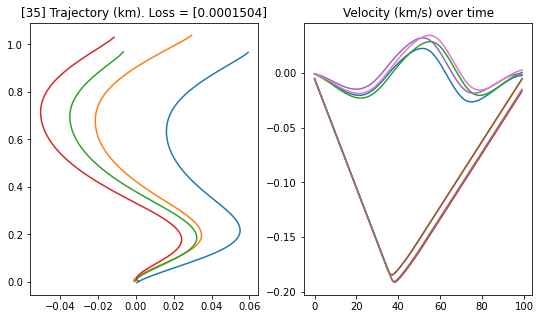

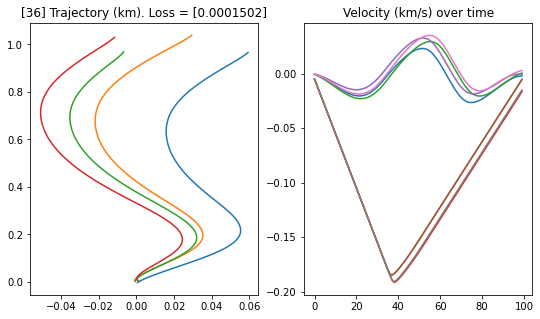

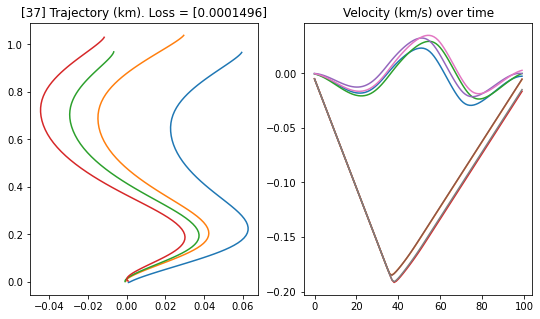

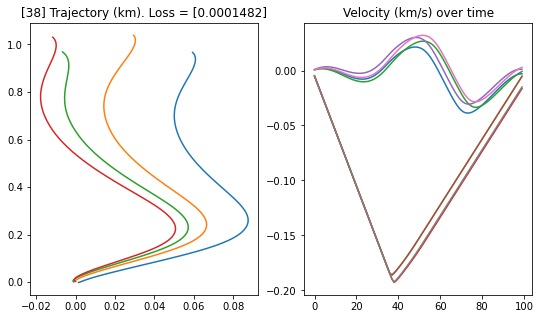

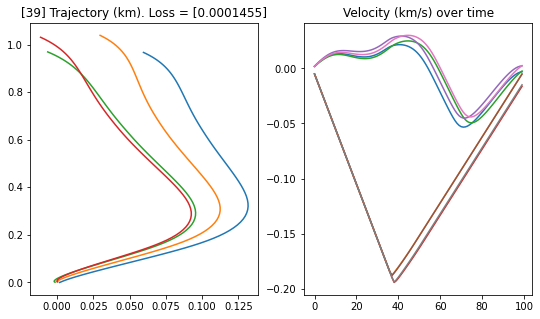

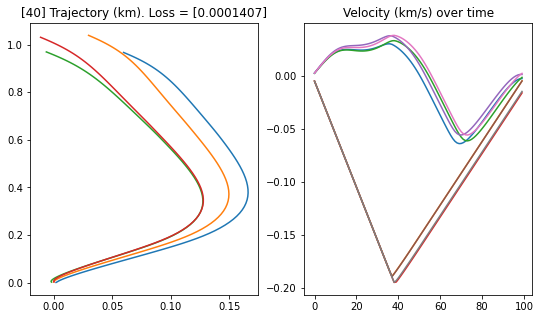

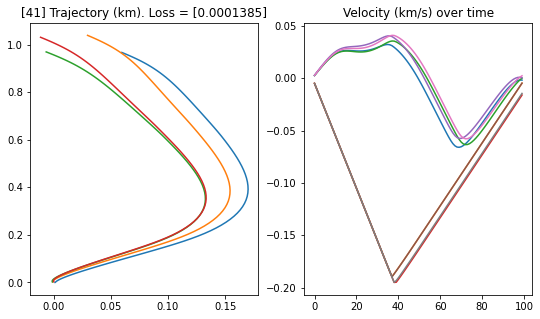

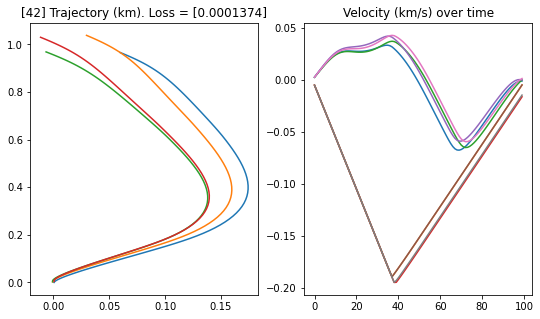

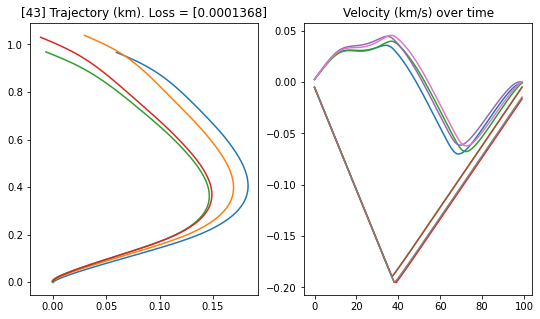

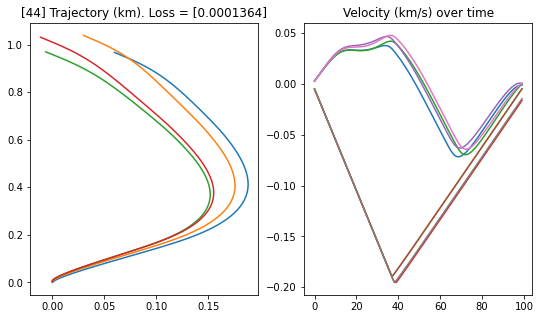

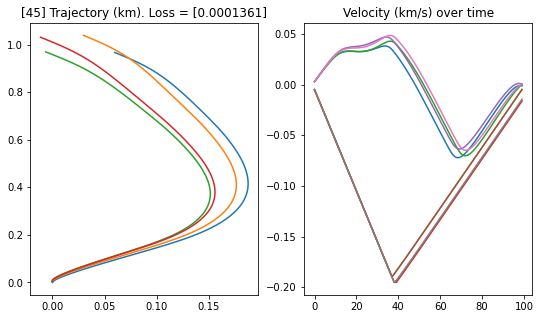

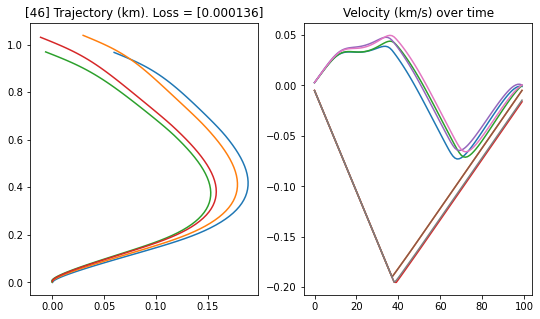

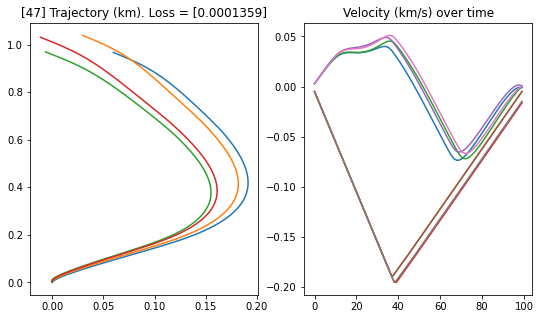

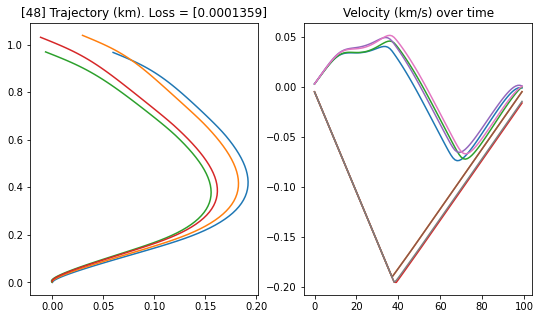

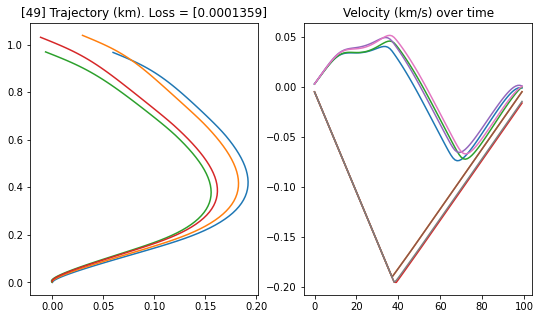

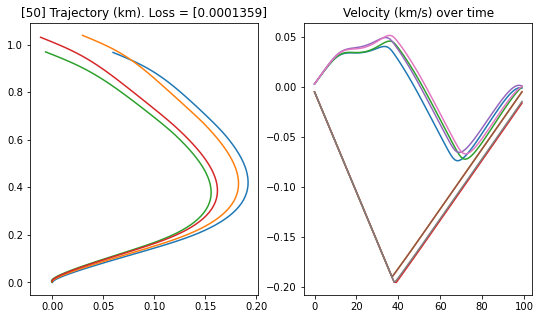

In [8]:
# Time to RUN!
T = 100  # number of time steps
dim_input = 4  # STATE SPACE dimensions
dim_hidden = 8  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # SOLVE THIS BOI
